In [2]:
import cv2
import numpy as np
import splitfolders
import tensorflow as tf

import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import timm

from keras_segmentation.models.unet import vgg_unet

import time
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize

#Reference
#https://www.kaggle.com/code/bulentsiyah/deep-learning-based-semantic-segmentation-keras
#https://github.com/gabrielchao/terrainclassifier


In [3]:
# Define hyperparameters
BATCH_SIZE = 32
EPOCHS = 1 #Changed to 1 epoch in case of accidental run
LR = 1e-4
IMG_SIZE = 224  # Patch size for VIT
NUM_CLASSES = 23  # Number of classes in the segmentation dataset
NUM_PATCHES = (IMG_SIZE // 16) ** 2  # Number of patches in the image
EMBED_DIM = 27  # VIT's default embedding dimension
NUM_HEADS = 12  # Number of attention heads in the transformer
NUM_TRANSFORMER_LAYERS = 12  # Number of transformer layers

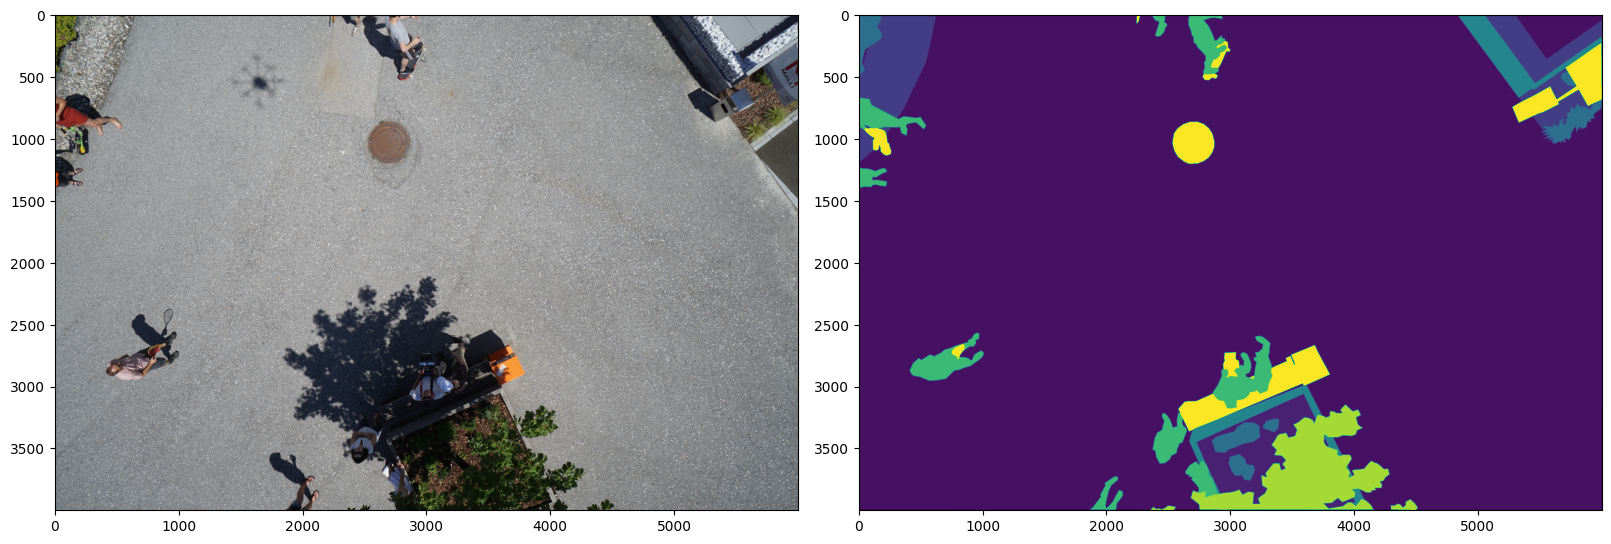

In [86]:

%matplotlib inline

original_image = "datasets\semantic_drone_dataset\original_images/class1/000.jpg"
label_image_semantic = "datasets\semantic_drone_dataset\label_images_semantic/class1/000.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)
axs[1].imshow(label_image_semantic)
axs[1].grid(False)

In [4]:
train_images = 'output_images/train/class1/'
test_images = 'output_images/val/class1/'
train_labels = 'output_labels/train/class1/'
test_labels = 'output_labels/val/class1/'

In [287]:
height = 416
width = 608

n_classes = 23 # Aerial Semantic Segmentation Drone Dataset tree, gras, other vegetation, dirt, gravel, rocks, water, paved area, pool, person, dog, car, bicycle, roof, wall, fence, fence-pole, window, door, obstacle
model = vgg_unet(n_classes=n_classes ,  input_height=height, input_width=width  )

In [289]:
model.load_weights('kaggle_first_run.h5')
model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [92]:
model.train( 
    train_images =  train_images,
    train_annotations = train_labels,
    checkpoints_path = "vgg_unet" , epochs=EPOCHS
)

Verifying training dataset


  0%|          | 0/280 [00:00<?, ?it/s]

100%|██████████| 280/280 [02:05<00:00,  2.24it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 1816s 4s/step - loss: 1.7606 - accuracy: 0.5650
Epoch 2/5
512/512 [==============================] - 1814s 4s/step - loss: 1.7552 - accuracy: 0.5664
Epoch 3/5
512/512 [==============================] - 1819s 4s/step - loss: 1.7440 - accuracy: 0.5688
Epoch 4/5
512/512 [==============================] - 1834s 4s/step - loss: 1.7316 - accuracy: 0.5685
Epoch 5/5
512/512 [==============================] - 1858s 4s/step - loss: 1.7298 - accuracy: 0.5694


In [93]:
# Get the model's predictions on the validation dataset
predicted_masks = model.predict_multiple(
    inp_dir=test_images
)

  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 1s 656ms/step


  1%|          | 1/120 [00:01<02:14,  1.13s/it]

1/1 [==============================] - 1s 542ms/step


  2%|▏         | 2/120 [00:02<02:04,  1.06s/it]

1/1 [==============================] - 0s 484ms/step


  2%|▎         | 3/120 [00:03<01:57,  1.00s/it]

1/1 [==============================] - 0s 481ms/step


  3%|▎         | 4/120 [00:03<01:52,  1.03it/s]

1/1 [==============================] - 0s 480ms/step


  4%|▍         | 5/120 [00:04<01:49,  1.05it/s]

1/1 [==============================] - 0s 476ms/step


  5%|▌         | 6/120 [00:05<01:46,  1.07it/s]

1/1 [==============================] - 0s 492ms/step


  6%|▌         | 7/120 [00:06<01:46,  1.06it/s]

1/1 [==============================] - 1s 512ms/step


  7%|▋         | 8/120 [00:07<01:45,  1.06it/s]

1/1 [==============================] - 1s 517ms/step


  8%|▊         | 9/120 [00:08<01:46,  1.04it/s]

1/1 [==============================] - 0s 466ms/step


  8%|▊         | 10/120 [00:09<01:43,  1.06it/s]

1/1 [==============================] - 0s 459ms/step


  9%|▉         | 11/120 [00:10<01:42,  1.07it/s]

1/1 [==============================] - 0s 454ms/step


 10%|█         | 12/120 [00:11<01:39,  1.08it/s]

1/1 [==============================] - 0s 464ms/step


 11%|█         | 13/120 [00:12<01:38,  1.09it/s]

1/1 [==============================] - 0s 472ms/step


 12%|█▏        | 14/120 [00:13<01:36,  1.09it/s]

1/1 [==============================] - 0s 484ms/step


 12%|█▎        | 15/120 [00:14<01:36,  1.09it/s]

1/1 [==============================] - 0s 441ms/step


 13%|█▎        | 16/120 [00:15<01:34,  1.10it/s]

1/1 [==============================] - 0s 463ms/step


 14%|█▍        | 17/120 [00:15<01:34,  1.09it/s]

1/1 [==============================] - 0s 493ms/step


 15%|█▌        | 18/120 [00:16<01:33,  1.09it/s]

1/1 [==============================] - 0s 466ms/step


 16%|█▌        | 19/120 [00:17<01:33,  1.08it/s]

1/1 [==============================] - 0s 463ms/step


 17%|█▋        | 20/120 [00:18<01:31,  1.09it/s]

1/1 [==============================] - 0s 447ms/step


 18%|█▊        | 21/120 [00:19<01:29,  1.11it/s]

1/1 [==============================] - 0s 451ms/step


 18%|█▊        | 22/120 [00:20<01:28,  1.11it/s]

1/1 [==============================] - 0s 444ms/step


 19%|█▉        | 23/120 [00:21<01:26,  1.12it/s]

1/1 [==============================] - 0s 464ms/step


 20%|██        | 24/120 [00:22<01:25,  1.12it/s]

1/1 [==============================] - 0s 447ms/step


 21%|██        | 25/120 [00:23<01:24,  1.13it/s]

1/1 [==============================] - 0s 450ms/step


 22%|██▏       | 26/120 [00:24<01:23,  1.12it/s]

1/1 [==============================] - 0s 463ms/step


 22%|██▎       | 27/120 [00:24<01:23,  1.12it/s]

1/1 [==============================] - 0s 435ms/step


 23%|██▎       | 28/120 [00:25<01:20,  1.14it/s]

1/1 [==============================] - 0s 452ms/step


 24%|██▍       | 29/120 [00:26<01:19,  1.15it/s]

1/1 [==============================] - 0s 433ms/step


 25%|██▌       | 30/120 [00:27<01:17,  1.15it/s]

1/1 [==============================] - 0s 445ms/step


 26%|██▌       | 31/120 [00:28<01:16,  1.16it/s]

1/1 [==============================] - 0s 440ms/step


 27%|██▋       | 32/120 [00:29<01:16,  1.15it/s]

1/1 [==============================] - 0s 426ms/step


 28%|██▊       | 33/120 [00:30<01:15,  1.16it/s]

1/1 [==============================] - 0s 426ms/step


 28%|██▊       | 34/120 [00:30<01:13,  1.17it/s]

1/1 [==============================] - 0s 462ms/step


 29%|██▉       | 35/120 [00:31<01:14,  1.15it/s]

1/1 [==============================] - 0s 434ms/step


 30%|███       | 36/120 [00:32<01:12,  1.15it/s]

1/1 [==============================] - 0s 441ms/step


 31%|███       | 37/120 [00:33<01:11,  1.16it/s]

1/1 [==============================] - 0s 445ms/step


 32%|███▏      | 38/120 [00:34<01:11,  1.15it/s]

1/1 [==============================] - 0s 435ms/step


 32%|███▎      | 39/120 [00:35<01:10,  1.15it/s]

1/1 [==============================] - 0s 454ms/step


 33%|███▎      | 40/120 [00:36<01:10,  1.14it/s]

1/1 [==============================] - 0s 450ms/step


 34%|███▍      | 41/120 [00:37<01:08,  1.15it/s]

1/1 [==============================] - 0s 429ms/step


 35%|███▌      | 42/120 [00:37<01:07,  1.16it/s]

1/1 [==============================] - 0s 434ms/step


 36%|███▌      | 43/120 [00:38<01:06,  1.16it/s]

1/1 [==============================] - 0s 453ms/step


 37%|███▋      | 44/120 [00:39<01:05,  1.16it/s]

1/1 [==============================] - 0s 448ms/step


 38%|███▊      | 45/120 [00:40<01:05,  1.15it/s]

1/1 [==============================] - 0s 478ms/step


 38%|███▊      | 46/120 [00:41<01:05,  1.14it/s]

1/1 [==============================] - 1s 507ms/step


 39%|███▉      | 47/120 [00:42<01:06,  1.10it/s]

1/1 [==============================] - 0s 452ms/step


 40%|████      | 48/120 [00:43<01:06,  1.09it/s]

1/1 [==============================] - 0s 490ms/step


 41%|████      | 49/120 [00:44<01:05,  1.09it/s]

1/1 [==============================] - 0s 481ms/step


 42%|████▏     | 50/120 [00:45<01:03,  1.10it/s]

1/1 [==============================] - 0s 429ms/step


 42%|████▎     | 51/120 [00:46<01:02,  1.11it/s]

1/1 [==============================] - 0s 436ms/step


 43%|████▎     | 52/120 [00:46<01:00,  1.13it/s]

1/1 [==============================] - 0s 445ms/step


 44%|████▍     | 53/120 [00:47<00:59,  1.13it/s]

1/1 [==============================] - 0s 450ms/step


 45%|████▌     | 54/120 [00:48<00:57,  1.15it/s]

1/1 [==============================] - 0s 437ms/step


 46%|████▌     | 55/120 [00:49<00:56,  1.15it/s]

1/1 [==============================] - 0s 436ms/step


 47%|████▋     | 56/120 [00:50<00:55,  1.15it/s]

1/1 [==============================] - 0s 442ms/step


 48%|████▊     | 57/120 [00:51<00:55,  1.14it/s]

1/1 [==============================] - 0s 486ms/step


 48%|████▊     | 58/120 [00:52<00:55,  1.11it/s]

1/1 [==============================] - 0s 473ms/step


 49%|████▉     | 59/120 [00:53<00:55,  1.10it/s]

1/1 [==============================] - 0s 434ms/step


 50%|█████     | 60/120 [00:53<00:53,  1.12it/s]

1/1 [==============================] - 0s 442ms/step


 51%|█████     | 61/120 [00:54<00:52,  1.12it/s]

1/1 [==============================] - 0s 448ms/step


 52%|█████▏    | 62/120 [00:55<00:51,  1.13it/s]

1/1 [==============================] - 0s 459ms/step


 52%|█████▎    | 63/120 [00:56<00:50,  1.13it/s]

1/1 [==============================] - 1s 503ms/step


 53%|█████▎    | 64/120 [00:57<00:50,  1.11it/s]

1/1 [==============================] - 0s 437ms/step


 54%|█████▍    | 65/120 [00:58<00:49,  1.11it/s]

1/1 [==============================] - 0s 432ms/step


 55%|█████▌    | 66/120 [00:59<00:47,  1.13it/s]

1/1 [==============================] - 0s 479ms/step


 56%|█████▌    | 67/120 [01:00<00:47,  1.12it/s]

1/1 [==============================] - 0s 481ms/step


 57%|█████▋    | 68/120 [01:01<00:46,  1.11it/s]

1/1 [==============================] - 0s 494ms/step


 57%|█████▊    | 69/120 [01:02<00:46,  1.10it/s]

1/1 [==============================] - 1s 553ms/step


 58%|█████▊    | 70/120 [01:03<00:46,  1.07it/s]

1/1 [==============================] - 0s 440ms/step


 59%|█████▉    | 71/120 [01:03<00:45,  1.08it/s]

1/1 [==============================] - 1s 523ms/step


 60%|██████    | 72/120 [01:04<00:45,  1.06it/s]

1/1 [==============================] - 1s 508ms/step


 61%|██████    | 73/120 [01:05<00:44,  1.06it/s]

1/1 [==============================] - 1s 543ms/step


 62%|██████▏   | 74/120 [01:06<00:44,  1.04it/s]

1/1 [==============================] - 0s 497ms/step


 62%|██████▎   | 75/120 [01:07<00:43,  1.04it/s]

1/1 [==============================] - 0s 494ms/step


 63%|██████▎   | 76/120 [01:08<00:42,  1.05it/s]

1/1 [==============================] - 0s 450ms/step


 64%|██████▍   | 77/120 [01:09<00:40,  1.06it/s]

1/1 [==============================] - 0s 433ms/step


 65%|██████▌   | 78/120 [01:10<00:38,  1.09it/s]

1/1 [==============================] - 0s 463ms/step


 66%|██████▌   | 79/120 [01:11<00:37,  1.10it/s]

1/1 [==============================] - 0s 454ms/step


 67%|██████▋   | 80/120 [01:12<00:36,  1.10it/s]

1/1 [==============================] - 0s 430ms/step


 68%|██████▊   | 81/120 [01:13<00:35,  1.10it/s]

1/1 [==============================] - 0s 436ms/step


 68%|██████▊   | 82/120 [01:14<00:34,  1.12it/s]

1/1 [==============================] - 0s 446ms/step


 69%|██████▉   | 83/120 [01:15<00:32,  1.12it/s]

1/1 [==============================] - 0s 483ms/step


 70%|███████   | 84/120 [01:15<00:32,  1.10it/s]

1/1 [==============================] - 0s 470ms/step


 71%|███████   | 85/120 [01:16<00:31,  1.10it/s]

1/1 [==============================] - 1s 529ms/step


 72%|███████▏  | 86/120 [01:17<00:31,  1.07it/s]

1/1 [==============================] - 0s 464ms/step


 72%|███████▎  | 87/120 [01:18<00:31,  1.06it/s]

1/1 [==============================] - 1s 515ms/step


 73%|███████▎  | 88/120 [01:19<00:30,  1.05it/s]

1/1 [==============================] - 0s 475ms/step


 74%|███████▍  | 89/120 [01:20<00:29,  1.05it/s]

1/1 [==============================] - 1s 503ms/step


 75%|███████▌  | 90/120 [01:21<00:28,  1.05it/s]

1/1 [==============================] - 0s 452ms/step


 76%|███████▌  | 91/120 [01:22<00:27,  1.07it/s]

1/1 [==============================] - 0s 455ms/step


 77%|███████▋  | 92/120 [01:23<00:25,  1.08it/s]

1/1 [==============================] - 0s 458ms/step


 78%|███████▊  | 93/120 [01:24<00:24,  1.09it/s]

1/1 [==============================] - 0s 451ms/step


 78%|███████▊  | 94/120 [01:25<00:23,  1.10it/s]

1/1 [==============================] - 1s 501ms/step


 79%|███████▉  | 95/120 [01:26<00:22,  1.09it/s]

1/1 [==============================] - 0s 479ms/step


 80%|████████  | 96/120 [01:27<00:22,  1.07it/s]

1/1 [==============================] - 0s 458ms/step


 81%|████████  | 97/120 [01:28<00:21,  1.07it/s]

1/1 [==============================] - 0s 488ms/step


 82%|████████▏ | 98/120 [01:29<00:20,  1.06it/s]

1/1 [==============================] - 0s 479ms/step


 82%|████████▎ | 99/120 [01:30<00:19,  1.06it/s]

1/1 [==============================] - 0s 494ms/step


 83%|████████▎ | 100/120 [01:30<00:18,  1.06it/s]

1/1 [==============================] - 0s 448ms/step


 84%|████████▍ | 101/120 [01:31<00:17,  1.07it/s]

1/1 [==============================] - 1s 519ms/step


 85%|████████▌ | 102/120 [01:32<00:17,  1.05it/s]

1/1 [==============================] - 1s 507ms/step


 86%|████████▌ | 103/120 [01:33<00:16,  1.04it/s]

1/1 [==============================] - 0s 468ms/step


 87%|████████▋ | 104/120 [01:34<00:15,  1.06it/s]

1/1 [==============================] - 0s 446ms/step


 88%|████████▊ | 105/120 [01:35<00:13,  1.07it/s]

1/1 [==============================] - 0s 453ms/step


 88%|████████▊ | 106/120 [01:36<00:12,  1.09it/s]

1/1 [==============================] - 0s 497ms/step


 89%|████████▉ | 107/120 [01:37<00:12,  1.07it/s]

1/1 [==============================] - 0s 488ms/step


 90%|█████████ | 108/120 [01:38<00:11,  1.07it/s]

1/1 [==============================] - 0s 449ms/step


 91%|█████████ | 109/120 [01:39<00:10,  1.09it/s]

1/1 [==============================] - 0s 467ms/step


 92%|█████████▏| 110/120 [01:40<00:09,  1.09it/s]

1/1 [==============================] - 0s 456ms/step


 92%|█████████▎| 111/120 [01:41<00:08,  1.08it/s]

1/1 [==============================] - 0s 460ms/step


 93%|█████████▎| 112/120 [01:42<00:07,  1.08it/s]

1/1 [==============================] - 0s 486ms/step


 94%|█████████▍| 113/120 [01:43<00:06,  1.08it/s]

1/1 [==============================] - 0s 461ms/step


 95%|█████████▌| 114/120 [01:43<00:05,  1.08it/s]

1/1 [==============================] - 0s 497ms/step


 96%|█████████▌| 115/120 [01:44<00:04,  1.07it/s]

1/1 [==============================] - 0s 485ms/step


 97%|█████████▋| 116/120 [01:45<00:03,  1.06it/s]

1/1 [==============================] - 0s 455ms/step


 98%|█████████▊| 117/120 [01:46<00:02,  1.08it/s]

1/1 [==============================] - 0s 445ms/step


 98%|█████████▊| 118/120 [01:47<00:01,  1.09it/s]

1/1 [==============================] - 0s 489ms/step


 99%|█████████▉| 119/120 [01:48<00:00,  1.08it/s]

1/1 [==============================] - 0s 456ms/step


100%|██████████| 120/120 [01:49<00:00,  1.10it/s]


In [94]:
model.save_weights('kaggle_first_run.h5')

In [95]:
np.save('vgg_unet_pred_labels.npy', predicted_masks)

In [96]:
predicted_masks = np.load('vgg_unet_pred_labels.npy')

In [151]:
# Evaluate Predictions compared to Truth
num_classes = NUM_CLASSES

# List all the files in the directory
mask_files = os.listdir(test_labels)

# Create an empty list to store the loaded masks
ground_truth_masks = []
# Loop through each mask file and load it
for mask_file in mask_files:
    # Create the full file path
    mask_path = os.path.join(test_labels, mask_file)

    # Open the image using PIL and convert it to grayscale (mode 'L')
    mask_img = Image.open(mask_path).convert('L')

    # Convert the image to a NumPy array
    mask_array = np.array(mask_img)
    ground_truth_masks.append(mask_array)

In [135]:
#Normalize ground_truth_masks
ground_truth_masks = [resize(mask, (IMG_SIZE,IMG_SIZE)) for mask in ground_truth_masks]
ground_truth_masks = np.array(ground_truth_masks)

# Normalized [0,1]
ground_truth_masks = (ground_truth_masks - np.min(ground_truth_masks))/np.ptp(ground_truth_masks)

ground_truth_masks = ground_truth_masks*(NUM_CLASSES)
ground_truth_masks = np.rint(ground_truth_masks)

In [99]:
#Normalize predicted masks
# Resize the predicted masks to match the size of ground truth masks
resized_predicted_masks = [resize(mask, ground_truth_masks[0].shape) for mask in predicted_masks]
resized_predicted_masks = np.array(resized_predicted_masks)

# Normalized [0,1]
resized_predicted_masks = (resized_predicted_masks - np.min(resized_predicted_masks))/np.ptp(resized_predicted_masks)

resized_predicted_masks = resized_predicted_masks*(NUM_CLASSES)
resized_predicted_masks = np.rint(resized_predicted_masks)

In [20]:
# Calculate IoU for each class
def calculate_iou(conf_matrix, class_index):
    intersection = conf_matrix[class_index, class_index]
    union = conf_matrix[class_index, :].sum() + conf_matrix[:, class_index].sum() - intersection
    iou = intersection / union
    return iou

# Calculate mIoU (mean IoU) for all classes
def calculate_miou(conf_matrix):
    num_classes = conf_matrix.shape[0]
    iou_list = []
    for class_index in range(num_classes):
        iou = calculate_iou(conf_matrix, class_index)
        iou_list.append(iou)
    miou = sum(iou_list) / num_classes
    return miou

In [101]:
# Flatten the masks to 1D arrays
predicted_masks_flat = resized_predicted_masks.reshape(-1)
ground_truth_masks_flat = ground_truth_masks.reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(ground_truth_masks_flat, predicted_masks_flat)
print(f"Accuracy: {accuracy}\n")

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth_masks_flat, predicted_masks_flat)

# Calculate classification report
class_report = classification_report(ground_truth_masks_flat, predicted_masks_flat)
print("Classification Report:")
print(class_report)

#Calculoute Miou
print("Mean Intersection over Union:")
print(calculate_miou(conf_matrix), '\n')

print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.524419709289966

Classification Report:
              precision    recall  f1-score   support

         0.0       0.01      0.09      0.01       469
         1.0       0.69      0.88      0.77   2162590
         2.0       0.13      0.12      0.12    240974
         3.0       0.63      0.60      0.62   1149987
         4.0       0.43      0.43      0.43    475853
         5.0       0.10      0.10      0.10    190413
         6.0       0.04      0.05      0.05     96364
         7.0       0.03      0.04      0.03     71199
         8.0       0.42      0.45      0.43    410333
         9.0       0.50      0.28      0.36    396087
        10.0       0.07      0.02      0.04    150097
        11.0       0.02      0.03      0.02     35583
        12.0       0.01      0.01      0.01     31136
        13.0       0.01      0.02      0.01     20351
        14.0       0.02      0.01      0.02     40059
        15.0       0.02      0.02      0.02     17115
        16.0       0.05      

1/1 [==============================] - 1s 915ms/step
Time elapsed for prediction:  1.9582536220550537


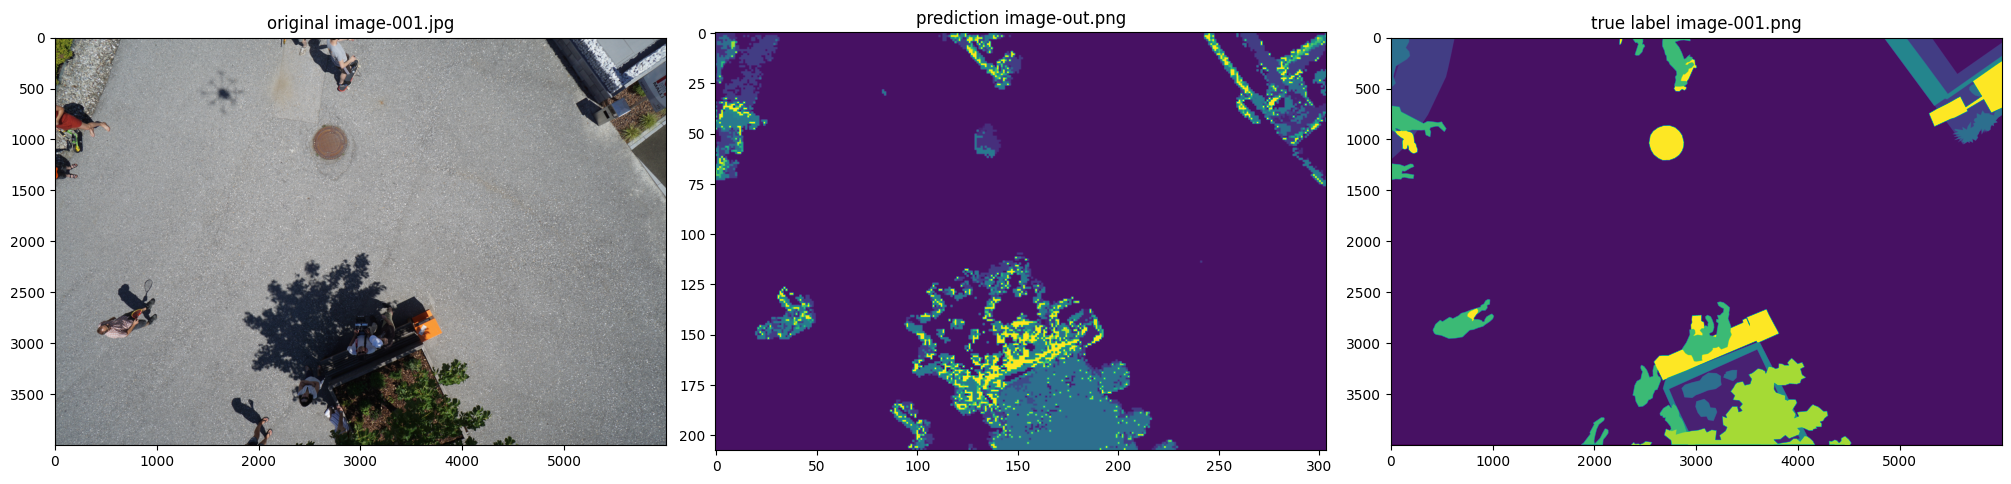

In [291]:
#PREDICTION OF THE VGG MODEL
%matplotlib inline

start = time.time()

input_image = "datasets/semantic_drone_dataset/original_images/class1/000.jpg"
out = model.predict_segmentation(
    inp=input_image
)

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open(input_image)
axs[0].imshow(img_orig)
axs[0].set_title('original image-001.jpg')
axs[0].grid(False)

axs[1].imshow(out)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = "datasets/semantic_drone_dataset/label_images_semantic/class1/000.png"
axs[2].imshow( Image.open(validation_image))
axs[2].set_title('true label image-001.png')
axs[2].grid(False)

done = time.time()
elapsed = done - start
print('Time elapsed for prediction: ', elapsed)

In [ ]:
class ViT_Segmentation(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(ViT_Segmentation, self).__init__()
        
        # Load the pre-trained ViT model
        self.vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

        # Get the number of input features to the classifier head
        num_features = self.vit_model.head.in_features

        # Modify the classifier head to match the number of classes in the segmentation dataset
        self.vit_model.head = nn.Linear(num_features, num_classes * IMG_SIZE * IMG_SIZE)

    def forward(self, x):
        # Apply the pre-trained ViT model
        x = self.vit_model(x)

        # Reshape the output to [batch_size, num_classes, IMG_SIZE, IMG_SIZE]
        x = x.view(x.size(0), NUM_CLASSES, IMG_SIZE, IMG_SIZE)

        return x

In [234]:
# Custom dataset for semantic segmentation
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))
        self.label_paths = glob.glob(os.path.join(label_dir, "*.png"))
        self.num_classes = NUM_CLASSES
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        image = Image.open(image_path)
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Resize the label to match the patch size (224x224)
        label = F.interpolate(label.unsqueeze(0), size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
        label = label.squeeze(0)

        # Convert the label to integer class labels
        label = torch.squeeze(label)  # Remove the channel dimension
        # Normalized [0,1]
        #label = (label - torch.min(label)) / (torch.max(label) - torch.min(label))
        #label = label*(NUM_CLASSES-1)
        #label = torch.round(label)

        return image, label

# Data preprocessing and loading
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])



In [275]:
#VIT MODEL TRAINING

dataset = SegmentationDataset(train_images, train_labels, transform=data_transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model and optimizer setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_Segmentation().to(device)
model.load_state_dict(torch.load("VIT_weights.pth"))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_function = nn.CrossEntropyLoss ()

In [276]:
# Training loop

print("Starting Training")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_correct_pixels = 0
    total_pixels = 0

    for batch_idx, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # print(outputs.shape)
        # print(len(torch.unique(outputs)))
        # print(outputs.min())
        # print(outputs.max())


        # print(labels.shape)
        # print(len(torch.unique(labels)))
        # print(labels.min())
        # print(labels.max())

        labels = labels.long()
        loss = loss_function(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy for this batch
        predictions = torch.argmax(outputs, dim=1)
        correct_pixels = torch.sum(predictions == labels)
        total_correct_pixels += correct_pixels.item()
        total_pixels += labels.numel()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct_pixels / total_pixels
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

print("Training complete.")

Starting Training
Epoch 1/1, Loss: 0.2911, Accuracy: 0.9540
Training complete.


In [278]:
#VIT MODEL EVAL

dataset = SegmentationDataset(test_images, test_labels, transform=data_transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model.eval()  # Set the model to evaluation mode

# Lists to store predictions and ground truth masks
predicted_masks = []
ground_truth = []

with torch.no_grad():
    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        predicted_masks.extend(outputs.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())

In [279]:
# Convert to numpy arrays
predicted_masks = np.array(predicted_masks)
ground_truth_masks = np.array(ground_truth)

#Normalize ground_truth_masks
ground_truth_masks = [resize(mask, (IMG_SIZE,IMG_SIZE)) for mask in ground_truth_masks]
ground_truth_masks = np.array(ground_truth_masks)

# Normalized [0,1]
ground_truth_masks = (ground_truth_masks - np.min(ground_truth_masks))/np.ptp(ground_truth_masks)

ground_truth_masks = ground_truth_masks*(NUM_CLASSES-1)
ground_truth_masks = np.rint(ground_truth_masks)

In [280]:
#Convert predictions to grayscale
resized_predicted_masks = np.mean(predicted_masks, axis=1)

#Normalize predicted masks
# Resize the predicted masks to match the size of ground truth masks
resized_predicted_masks = [resize(mask, ground_truth_masks[0].shape) for mask in resized_predicted_masks]
resized_predicted_masks = np.array(resized_predicted_masks)

# Normalised [0,1]
resized_predicted_masks = (resized_predicted_masks - np.min(resized_predicted_masks))/np.ptp(resized_predicted_masks)

resized_predicted_masks = resized_predicted_masks*(NUM_CLASSES-1)
resized_predicted_masks = np.rint(resized_predicted_masks)

In [281]:
# Calculate mIoU Function
def mean_iou(y_true, y_pred):
    
    # Initialize Intersection and Union counters for each class
    intersection = np.zeros(NUM_CLASSES)
    union = np.zeros(NUM_CLASSES)
    
    # Calculate Intersection and Union for each class
    for class_id in range(1, NUM_CLASSES):
        y_pred_class = (y_pred == class_id)
        y_true_class = (y_true == class_id)
        
        intersection[class_id] = np.sum(np.logical_and(y_pred_class, y_true_class))
        union[class_id] = np.sum(np.logical_or(y_pred_class, y_true_class))
    
    # Calculate IoU for each class (avoid division by zero)
    iou = np.divide(intersection, union, out=np.zeros_like(intersection), where=union != 0)
    
    # Calculate mIoU by averaging over classes (excluding background)
    miou = np.mean(iou[1:])
    
    return miou

In [282]:
# Flatten the masks to 1D arrays
predicted_classes = resized_predicted_masks.flatten()
ground_truth_classes = ground_truth_masks.flatten()

accuracy = accuracy_score(ground_truth_classes, predicted_classes)
print(f"Accuracy: {accuracy}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth_classes, predicted_classes)

# Calculate classification report
class_report = classification_report(ground_truth_classes, predicted_classes)
print("Classification Report:")
print(class_report)

miou = mean_iou(ground_truth_classes, predicted_classes)
print(f"mIoU: {miou}")

print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.02554292224702381
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       495
         1.0       0.37      0.00      0.00   2183818
         2.0       0.04      0.00      0.00    238596
         3.0       0.18      0.00      0.00   1150084
         4.0       0.08      0.01      0.01    483483
         5.0       0.03      0.02      0.02    182388
         6.0       0.02      0.04      0.02     92444
         7.0       0.01      0.07      0.02     71069
         8.0       0.07      0.11      0.08    411846
         9.0       0.07      0.14      0.09    395475
        10.0       0.02      0.15      0.04    148735
        11.0       0.01      0.15      0.01     43328
        12.0       0.00      0.12      0.01     16322
        13.0       0.01      0.09      0.01     44679
        14.0       0.00      0.05      0.00     14076
        15.0       0.01      0.03      0.01     53069
        16.0       0.00     

In [283]:
torch.save(model.state_dict(), "VIT_weights.pth")

In [284]:
#PREDICTION OF THE VIT MODEL
%matplotlib inline

start = time.time()

input_path = "datasets/semantic_drone_dataset/original_images/class1/000.jpg"
input_image = Image.open(input_path)

# Apply the necessary transformations to the image
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Replace IMG_SIZE with the desired size
    transforms.ToTensor(),
])

input_image = transform(input_image).unsqueeze(0).to(device)

# Perform the prediction
with torch.no_grad():
    outputs = model(input_image)

# Convert tensor to a PIL Image
outputs_numpy = outputs.squeeze().cpu().numpy()
outputs_numpy = (outputs_numpy * 255).astype(np.uint8)  # Assuming 8-bit image (uint8)
output_image = Image.fromarray(outputs_numpy[0])  # Access the first channel if needed

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open(input_path)
axs[0].imshow(img_orig)
axs[0].set_title('original image-001.jpg')
axs[0].grid(False)

axs[1].imshow(output_image)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = "datasets/semantic_drone_dataset/label_images_semantic/class1/000.png"
axs[2].imshow( Image.open(validation_image))
axs[2].set_title('true label image-001.png')
axs[2].grid(False)

done = time.time()
elapsed = done - start
print('Time elapsed for prediction: ', elapsed)

Time elapsed for prediction:  1.2941746711730957


In [9]:
height = 416
width = 608

from keras_segmentation.models import fcn

# Load the FCN-8 model with ResNet50 backbone
model = fcn.fcn_8(n_classes=NUM_CLASSES, input_height=height, input_width=width )

In [10]:
model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [11]:
model.train( 
    train_images =  train_images,
    train_annotations = train_labels,
    epochs=30
)

Verifying training dataset


  0%|          | 0/280 [00:00<?, ?it/s]

100%|██████████| 280/280 [02:08<00:00,  2.18it/s]


Dataset verified! 
512/512 [==============================] - 1193s 2s/step - loss: 3.1301 - accuracy: 0.0604


In [12]:
# Get the model's predictions on the validation dataset
predicted_masks = model.predict_multiple(
    inp_dir=test_images
)

  0%|          | 0/120 [00:00<?, ?it/s]

1/1 [==============================] - 0s 435ms/step


  1%|          | 1/120 [00:00<01:57,  1.01it/s]

1/1 [==============================] - 0s 247ms/step


  2%|▏         | 2/120 [00:01<01:43,  1.14it/s]

1/1 [==============================] - 0s 246ms/step


  2%|▎         | 3/120 [00:02<01:36,  1.22it/s]

1/1 [==============================] - 0s 241ms/step


  3%|▎         | 4/120 [00:03<01:31,  1.26it/s]

1/1 [==============================] - 0s 237ms/step


  4%|▍         | 5/120 [00:04<01:29,  1.28it/s]

1/1 [==============================] - 0s 245ms/step


  5%|▌         | 6/120 [00:04<01:28,  1.29it/s]

1/1 [==============================] - 0s 248ms/step


  6%|▌         | 7/120 [00:05<01:27,  1.29it/s]

1/1 [==============================] - 0s 252ms/step


  7%|▋         | 8/120 [00:06<01:27,  1.28it/s]

1/1 [==============================] - 0s 250ms/step


  8%|▊         | 9/120 [00:07<01:26,  1.29it/s]

1/1 [==============================] - 0s 273ms/step


  8%|▊         | 10/120 [00:07<01:26,  1.28it/s]

1/1 [==============================] - 0s 255ms/step


  9%|▉         | 11/120 [00:08<01:25,  1.28it/s]

1/1 [==============================] - 0s 240ms/step


 10%|█         | 12/120 [00:09<01:23,  1.29it/s]

1/1 [==============================] - 0s 257ms/step


 11%|█         | 13/120 [00:10<01:22,  1.29it/s]

1/1 [==============================] - 0s 246ms/step


 12%|█▏        | 14/120 [00:11<01:21,  1.31it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▎        | 15/120 [00:11<01:21,  1.29it/s]

1/1 [==============================] - 0s 256ms/step


 13%|█▎        | 16/120 [00:12<01:19,  1.30it/s]

1/1 [==============================] - 0s 222ms/step


 14%|█▍        | 17/120 [00:13<01:17,  1.33it/s]

1/1 [==============================] - 0s 227ms/step


 15%|█▌        | 18/120 [00:14<01:16,  1.33it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 19/120 [00:14<01:18,  1.29it/s]

1/1 [==============================] - 0s 228ms/step


 17%|█▋        | 20/120 [00:15<01:16,  1.31it/s]

1/1 [==============================] - 0s 251ms/step


 18%|█▊        | 21/120 [00:16<01:15,  1.31it/s]

1/1 [==============================] - 0s 242ms/step


 18%|█▊        | 22/120 [00:17<01:15,  1.31it/s]

1/1 [==============================] - 0s 248ms/step


 19%|█▉        | 23/120 [00:17<01:14,  1.31it/s]

1/1 [==============================] - 0s 238ms/step


 20%|██        | 24/120 [00:18<01:12,  1.33it/s]

1/1 [==============================] - 0s 246ms/step


 21%|██        | 25/120 [00:19<01:12,  1.32it/s]

1/1 [==============================] - 0s 239ms/step


 22%|██▏       | 26/120 [00:20<01:11,  1.32it/s]

1/1 [==============================] - 0s 249ms/step


 22%|██▎       | 27/120 [00:20<01:10,  1.32it/s]

1/1 [==============================] - 0s 241ms/step


 23%|██▎       | 28/120 [00:21<01:08,  1.33it/s]

1/1 [==============================] - 0s 234ms/step


 24%|██▍       | 29/120 [00:22<01:07,  1.34it/s]

1/1 [==============================] - 0s 237ms/step


 25%|██▌       | 30/120 [00:23<01:06,  1.35it/s]

1/1 [==============================] - 0s 245ms/step


 26%|██▌       | 31/120 [00:23<01:06,  1.33it/s]

1/1 [==============================] - 0s 268ms/step


 27%|██▋       | 32/120 [00:24<01:06,  1.32it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 33/120 [00:25<01:06,  1.32it/s]

1/1 [==============================] - 0s 236ms/step


 28%|██▊       | 34/120 [00:26<01:04,  1.32it/s]

1/1 [==============================] - 0s 246ms/step


 29%|██▉       | 35/120 [00:26<01:04,  1.33it/s]

1/1 [==============================] - 0s 250ms/step


 30%|███       | 36/120 [00:27<01:03,  1.33it/s]

1/1 [==============================] - 0s 237ms/step


 31%|███       | 37/120 [00:28<01:02,  1.34it/s]

1/1 [==============================] - 0s 233ms/step


 32%|███▏      | 38/120 [00:29<01:01,  1.34it/s]

1/1 [==============================] - 0s 242ms/step


 32%|███▎      | 39/120 [00:29<01:00,  1.33it/s]

1/1 [==============================] - 0s 240ms/step


 33%|███▎      | 40/120 [00:30<01:00,  1.33it/s]

1/1 [==============================] - 0s 237ms/step


 34%|███▍      | 41/120 [00:31<00:59,  1.33it/s]

1/1 [==============================] - 0s 236ms/step


 35%|███▌      | 42/120 [00:32<00:58,  1.33it/s]

1/1 [==============================] - 0s 253ms/step


 36%|███▌      | 43/120 [00:32<00:58,  1.32it/s]

1/1 [==============================] - 0s 244ms/step


 37%|███▋      | 44/120 [00:33<00:58,  1.30it/s]

1/1 [==============================] - 0s 237ms/step


 38%|███▊      | 45/120 [00:34<00:56,  1.32it/s]

1/1 [==============================] - 0s 240ms/step


 38%|███▊      | 46/120 [00:35<00:56,  1.32it/s]

1/1 [==============================] - 0s 239ms/step


 39%|███▉      | 47/120 [00:35<00:55,  1.31it/s]

1/1 [==============================] - 0s 244ms/step


 40%|████      | 48/120 [00:36<00:54,  1.31it/s]

1/1 [==============================] - 0s 239ms/step


 41%|████      | 49/120 [00:37<00:54,  1.31it/s]

1/1 [==============================] - 0s 240ms/step


 42%|████▏     | 50/120 [00:38<00:53,  1.32it/s]

1/1 [==============================] - 0s 239ms/step


 42%|████▎     | 51/120 [00:39<00:52,  1.32it/s]

1/1 [==============================] - 0s 244ms/step


 43%|████▎     | 52/120 [00:39<00:51,  1.32it/s]

1/1 [==============================] - 0s 236ms/step


 44%|████▍     | 53/120 [00:40<00:50,  1.33it/s]

1/1 [==============================] - 0s 237ms/step


 45%|████▌     | 54/120 [00:41<00:49,  1.34it/s]

1/1 [==============================] - 0s 241ms/step


 46%|████▌     | 55/120 [00:41<00:48,  1.34it/s]

1/1 [==============================] - 0s 242ms/step


 47%|████▋     | 56/120 [00:42<00:47,  1.34it/s]

1/1 [==============================] - 0s 243ms/step


 48%|████▊     | 57/120 [00:43<00:47,  1.32it/s]

1/1 [==============================] - 0s 236ms/step


 48%|████▊     | 58/120 [00:44<00:46,  1.32it/s]

1/1 [==============================] - 0s 250ms/step


 49%|████▉     | 59/120 [00:45<00:46,  1.31it/s]

1/1 [==============================] - 0s 248ms/step


 50%|█████     | 60/120 [00:45<00:45,  1.31it/s]

1/1 [==============================] - 0s 241ms/step


 51%|█████     | 61/120 [00:46<00:44,  1.32it/s]

1/1 [==============================] - 0s 239ms/step


 52%|█████▏    | 62/120 [00:47<00:43,  1.32it/s]

1/1 [==============================] - 0s 238ms/step


 52%|█████▎    | 63/120 [00:48<00:43,  1.32it/s]

1/1 [==============================] - 0s 241ms/step


 53%|█████▎    | 64/120 [00:48<00:42,  1.32it/s]

1/1 [==============================] - 0s 238ms/step


 54%|█████▍    | 65/120 [00:49<00:41,  1.32it/s]

1/1 [==============================] - 0s 245ms/step


 55%|█████▌    | 66/120 [00:50<00:41,  1.32it/s]

1/1 [==============================] - 0s 238ms/step


 56%|█████▌    | 67/120 [00:51<00:39,  1.33it/s]

1/1 [==============================] - 0s 242ms/step


 57%|█████▋    | 68/120 [00:51<00:39,  1.33it/s]

1/1 [==============================] - 0s 241ms/step


 57%|█████▊    | 69/120 [00:52<00:38,  1.33it/s]

1/1 [==============================] - 0s 240ms/step


 58%|█████▊    | 70/120 [00:53<00:37,  1.34it/s]

1/1 [==============================] - 0s 237ms/step


 59%|█████▉    | 71/120 [00:54<00:36,  1.34it/s]

1/1 [==============================] - 0s 244ms/step


 60%|██████    | 72/120 [00:54<00:36,  1.33it/s]

1/1 [==============================] - 0s 241ms/step


 61%|██████    | 73/120 [00:55<00:35,  1.33it/s]

1/1 [==============================] - 0s 235ms/step


 62%|██████▏   | 74/120 [00:56<00:34,  1.34it/s]

1/1 [==============================] - 0s 241ms/step


 62%|██████▎   | 75/120 [00:57<00:33,  1.33it/s]

1/1 [==============================] - 0s 245ms/step


 63%|██████▎   | 76/120 [00:57<00:33,  1.33it/s]

1/1 [==============================] - 0s 241ms/step


 64%|██████▍   | 77/120 [00:58<00:32,  1.33it/s]

1/1 [==============================] - 0s 239ms/step


 65%|██████▌   | 78/120 [00:59<00:31,  1.33it/s]

1/1 [==============================] - 0s 239ms/step


 66%|██████▌   | 79/120 [01:00<00:31,  1.31it/s]

1/1 [==============================] - 0s 248ms/step


 67%|██████▋   | 80/120 [01:00<00:30,  1.31it/s]

1/1 [==============================] - 0s 240ms/step


 68%|██████▊   | 81/120 [01:01<00:29,  1.31it/s]

1/1 [==============================] - 0s 237ms/step


 68%|██████▊   | 82/120 [01:02<00:28,  1.32it/s]

1/1 [==============================] - 0s 240ms/step


 69%|██████▉   | 83/120 [01:03<00:28,  1.32it/s]

1/1 [==============================] - 0s 255ms/step


 70%|███████   | 84/120 [01:04<00:27,  1.29it/s]

1/1 [==============================] - 0s 243ms/step


 71%|███████   | 85/120 [01:04<00:27,  1.29it/s]

1/1 [==============================] - 0s 242ms/step


 72%|███████▏  | 86/120 [01:05<00:26,  1.29it/s]

1/1 [==============================] - 0s 238ms/step


 72%|███████▎  | 87/120 [01:06<00:25,  1.29it/s]

1/1 [==============================] - 0s 237ms/step


 73%|███████▎  | 88/120 [01:07<00:24,  1.30it/s]

1/1 [==============================] - 0s 243ms/step


 74%|███████▍  | 89/120 [01:07<00:23,  1.30it/s]

1/1 [==============================] - 0s 242ms/step


 75%|███████▌  | 90/120 [01:08<00:23,  1.30it/s]

1/1 [==============================] - 0s 240ms/step


 76%|███████▌  | 91/120 [01:09<00:22,  1.30it/s]

1/1 [==============================] - 0s 237ms/step


 77%|███████▋  | 92/120 [01:10<00:21,  1.31it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 93/120 [01:10<00:20,  1.31it/s]

1/1 [==============================] - 0s 241ms/step


 78%|███████▊  | 94/120 [01:11<00:19,  1.32it/s]

1/1 [==============================] - 0s 239ms/step


 79%|███████▉  | 95/120 [01:12<00:18,  1.33it/s]

1/1 [==============================] - 0s 239ms/step


 80%|████████  | 96/120 [01:13<00:18,  1.33it/s]

1/1 [==============================] - 0s 246ms/step


 81%|████████  | 97/120 [01:13<00:17,  1.30it/s]

1/1 [==============================] - 0s 249ms/step


 82%|████████▏ | 98/120 [01:14<00:16,  1.31it/s]

1/1 [==============================] - 0s 237ms/step


 82%|████████▎ | 99/120 [01:15<00:16,  1.31it/s]

1/1 [==============================] - 0s 236ms/step


 83%|████████▎ | 100/120 [01:16<00:15,  1.31it/s]

1/1 [==============================] - 0s 236ms/step


 84%|████████▍ | 101/120 [01:16<00:14,  1.32it/s]

1/1 [==============================] - 0s 246ms/step


 85%|████████▌ | 102/120 [01:17<00:13,  1.32it/s]

1/1 [==============================] - 0s 245ms/step


 86%|████████▌ | 103/120 [01:18<00:12,  1.32it/s]

1/1 [==============================] - 0s 236ms/step


 87%|████████▋ | 104/120 [01:19<00:12,  1.32it/s]

1/1 [==============================] - 0s 236ms/step


 88%|████████▊ | 105/120 [01:19<00:11,  1.33it/s]

1/1 [==============================] - 0s 241ms/step


 88%|████████▊ | 106/120 [01:20<00:10,  1.32it/s]

1/1 [==============================] - 0s 236ms/step


 89%|████████▉ | 107/120 [01:21<00:09,  1.32it/s]

1/1 [==============================] - 0s 235ms/step


 90%|█████████ | 108/120 [01:22<00:09,  1.33it/s]

1/1 [==============================] - 0s 237ms/step


 91%|█████████ | 109/120 [01:22<00:08,  1.34it/s]

1/1 [==============================] - 0s 242ms/step


 92%|█████████▏| 110/120 [01:23<00:07,  1.33it/s]

1/1 [==============================] - 0s 237ms/step


 92%|█████████▎| 111/120 [01:24<00:06,  1.32it/s]

1/1 [==============================] - 0s 241ms/step


 93%|█████████▎| 112/120 [01:25<00:06,  1.33it/s]

1/1 [==============================] - 0s 238ms/step


 94%|█████████▍| 113/120 [01:25<00:05,  1.34it/s]

1/1 [==============================] - 0s 243ms/step


 95%|█████████▌| 114/120 [01:26<00:04,  1.33it/s]

1/1 [==============================] - 0s 240ms/step


 96%|█████████▌| 115/120 [01:27<00:03,  1.33it/s]

1/1 [==============================] - 0s 243ms/step


 97%|█████████▋| 116/120 [01:28<00:03,  1.33it/s]

1/1 [==============================] - 0s 238ms/step


 98%|█████████▊| 117/120 [01:29<00:02,  1.32it/s]

1/1 [==============================] - 0s 245ms/step


 98%|█████████▊| 118/120 [01:29<00:01,  1.31it/s]

1/1 [==============================] - 0s 240ms/step


 99%|█████████▉| 119/120 [01:30<00:00,  1.32it/s]

1/1 [==============================] - 0s 238ms/step


100%|██████████| 120/120 [01:31<00:00,  1.31it/s]


In [13]:
model.save_weights('fcn.h5')

In [14]:
np.save('fcn_pred_labels.npy', predicted_masks)

In [15]:
predicted_masks = np.load('fcn_pred_labels.npy')

In [16]:
# Evaluate Predictions compared to Truth
num_classes = NUM_CLASSES

# List all the files in the directory
mask_files = os.listdir(test_labels)

# Create an empty list to store the loaded masks
ground_truth_masks = []
# Loop through each mask file and load it
for mask_file in mask_files:
    # Create the full file path
    mask_path = os.path.join(test_labels, mask_file)

    # Open the image using PIL and convert it to grayscale (mode 'L')
    mask_img = Image.open(mask_path).convert('L')

    # Convert the image to a NumPy array
    mask_array = np.array(mask_img)
    ground_truth_masks.append(mask_array)

In [17]:
#Normalize ground_truth_masks
ground_truth_masks = [resize(mask, (IMG_SIZE,IMG_SIZE)) for mask in ground_truth_masks]
ground_truth_masks = np.array(ground_truth_masks)

# Normalized [0,1]
ground_truth_masks = (ground_truth_masks - np.min(ground_truth_masks))/np.ptp(ground_truth_masks)

ground_truth_masks = ground_truth_masks*(NUM_CLASSES)
ground_truth_masks = np.rint(ground_truth_masks)

In [18]:
#Normalize predicted masks
# Resize the predicted masks to match the size of ground truth masks
resized_predicted_masks = [resize(mask, ground_truth_masks[0].shape) for mask in predicted_masks]
resized_predicted_masks = np.array(resized_predicted_masks)

# Normalized [0,1]
resized_predicted_masks = (resized_predicted_masks - np.min(resized_predicted_masks))/np.ptp(resized_predicted_masks)

resized_predicted_masks = resized_predicted_masks*(NUM_CLASSES)
resized_predicted_masks = np.rint(resized_predicted_masks)

In [21]:
# Flatten the masks to 1D arrays
predicted_masks_flat = resized_predicted_masks.reshape(-1)
ground_truth_masks_flat = ground_truth_masks.reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(ground_truth_masks_flat, predicted_masks_flat)
print(f"Accuracy: {accuracy}\n")

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth_masks_flat, predicted_masks_flat)

# Calculate classification report
class_report = classification_report(ground_truth_masks_flat, predicted_masks_flat)
print("Classification Report:")
print(class_report)

#Calculoute Miou
print("Mean Intersection over Union:")
print(calculate_miou(conf_matrix), '\n')

print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.025314393335459182

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       469
         1.0       0.32      0.00      0.00   2162590
         2.0       0.04      0.00      0.00    240974
         3.0       0.17      0.01      0.01   1149987
         4.0       0.10      0.02      0.04    475853
         5.0       0.03      0.03      0.03    190413
         6.0       0.02      0.06      0.02     96364
         7.0       0.01      0.08      0.02     71199
         8.0       0.06      0.09      0.07    410333
         9.0       0.07      0.12      0.08    396087
        10.0       0.02      0.12      0.04    150097
        11.0       0.01      0.11      0.01     35583
        12.0       0.01      0.10      0.01     31136
        13.0       0.00      0.09      0.01     20351
        14.0       0.01      0.07      0.01     40059
        15.0       0.00      0.05      0.01     17115
        16.0       0.01   

1/1 [==============================] - 0s 278ms/step
Time elapsed for prediction:  1.3282074928283691


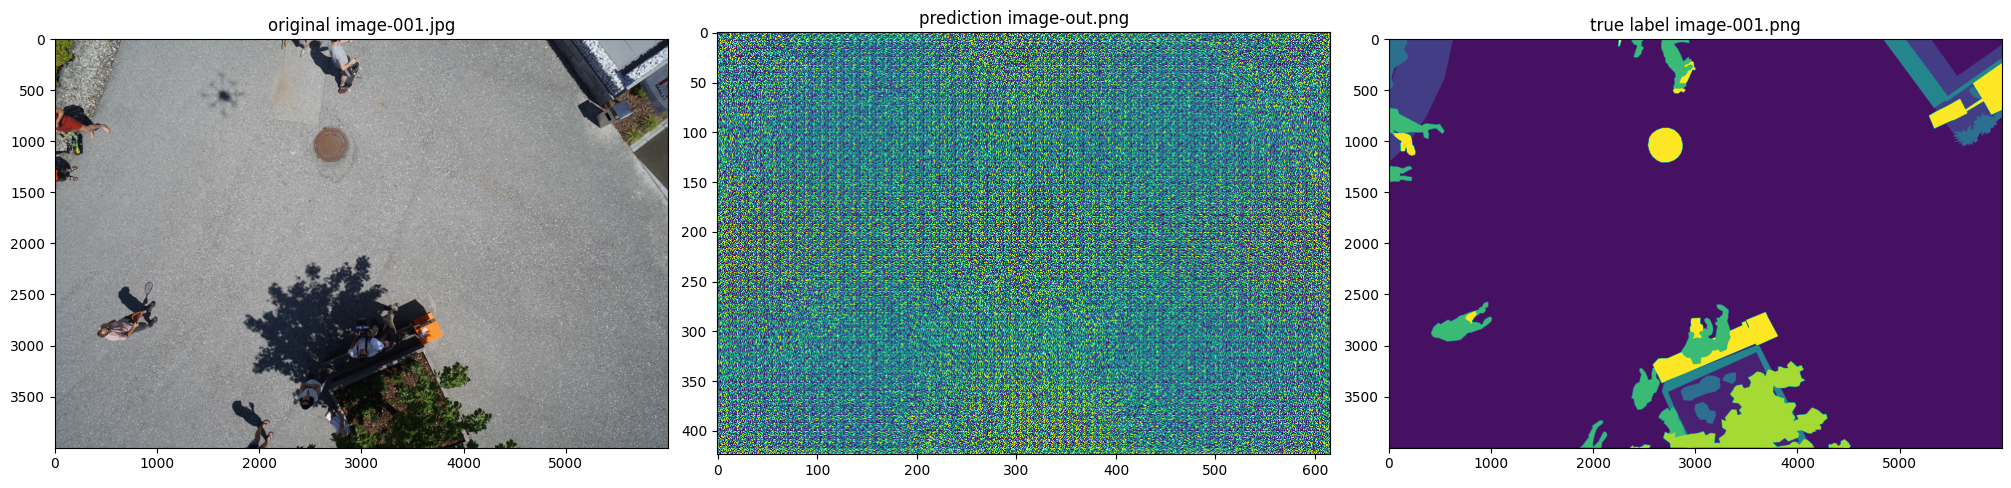

In [22]:
#PREDICTION OF THE FCN MODEL
%matplotlib inline

start = time.time()

input_image = "datasets/semantic_drone_dataset/original_images/class1/000.jpg"
out = model.predict_segmentation(
    inp=input_image
)

fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

img_orig = Image.open(input_image)
axs[0].imshow(img_orig)
axs[0].set_title('original image-001.jpg')
axs[0].grid(False)

axs[1].imshow(out)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = "datasets/semantic_drone_dataset/label_images_semantic/class1/000.png"
axs[2].imshow( Image.open(validation_image))
axs[2].set_title('true label image-001.png')
axs[2].grid(False)

done = time.time()
elapsed = done - start
print('Time elapsed for prediction: ', elapsed)